#### Imports


In [7]:
import seaborn as sns 
import polars as pl
import matplotlib.pyplot as plt
import pingouin as pg
import pandas as pd


### processsing functions

In [10]:



def get_injection_site(mouse_id, injection_dict):
    for site, mice in injection_dict.items():
        if mouse_id in mice:
            return site
    return None

injection_site_map = {
    'mouse_id': [id for ids in injection_site.values() for id in ids],
    'injection_site': [site for site, ids in injection_site.items() for id in ids]
}
injection_site_df = pl.DataFrame(injection_site_map)

def format_data_for_plotting(df, cols):
    injection_site = {
            'LHA': [20017817,
        20017818,
        20017819,
        20117654,
        20117655],
            'NAC': [20217850,
        20317860,
        20417815,
        20417816]
        }
    df = df.join(injection_site_df, on='mouse_id', how='inner')
    return (df
            .melt(id_vars=['label', 'mouse_id', 'region'], value_vars= cols,
                  variable_name = 'metric', value_name = 'value')
            .group_by(['mouse_id','metric', 'region']).agg([
                pl.col('value').mean().alias('mean'),
                pl.col('label').count().alias('count')
            ])
    )
plot_cols = ['count', 'mean_intensity', 'area']
def format_data_for_stats(df):
    return (df
            .filter(pl.col('metric').is_in(plot_cols))
            .drop('mouse_id')
            .pivot(on='metric', values='mean')
            .with_columns(pl.col('count').cast(pl.Float32))
            .to_pandas()
            
    )

### process and format

In [15]:
injection_site = {
    'LHA': [20017817,
20017818,
20017819,
20117654,
20117655],
    'NAC': [20217850,
20317860,
20417815,
20417816]
}

def get_injection_site(mouse_id, injection_dict):
    for site, mice in injection_dict.items():
        if mouse_id in mice:
            return site
    return None

injection_site_map = {
    'mouse_id': [id for ids in injection_site.values() for id in ids],
    'injection_site': [site for site, ids in injection_site.items() for id in ids]
}
injection_site_df = pl.DataFrame(injection_site_map)



mouse_id,injection_site
i64,str
20017817,"""LHA"""
20017818,"""LHA"""
20017819,"""LHA"""
20117654,"""LHA"""
20117655,"""LHA"""
20217850,"""NAC"""
20317860,"""NAC"""
20417815,"""NAC"""
20417816,"""NAC"""


In [11]:

# read data into polars
path = '/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Mike/LHA_dopamine/Retrograde_tracing/CAV_FRTCRE_THFLPO_dual_label/confocal_images/analyzed_data/analyzed_data.csv'
df = pl.read_csv(path)

#format data for plotting
cols = ['area', 'mean_intensity', 'equivalent_diameter', 'eccentricity', 'major_axis_length', 'minor_axis_length',  'solidity']
data = format_data_for_plotting(df, cols)


piv_data = format_data_for_stats(data)



/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_28617/1884075.py:3: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  .melt(id_vars=['label', 'mouse_id', 'region'], value_vars= cols,


In [13]:
data

mouse_id,metric,region,mean,count
i64,str,str,f64,u32
20317860,"""equivalent_diameter""","""LHA""",12.230957,1148
20417816,"""minor_axis_length""","""LHA""",9.316283,1164
20017550,"""major_axis_length""","""LHA""",22.396402,276
20317860,"""minor_axis_length""","""LHA""",9.200658,1148
20117654,"""minor_axis_length""","""NAC""",10.628575,1392
…,…,…,…,…
20117654,"""mean_intensity""","""NAC""",306.121727,1392
20317818,"""eccentricity""","""NAC""",0.818117,5536
20117655,"""area""","""NAC""",192.231634,2845


### Calculate ANOVA and save

In [12]:
count_anov = pg.anova(piv_data, dv = 'count', between='region', detailed=True)
intensity_anov = pg.anova(piv_data, dv = 'mean_intensity', between='region', detailed=True)
area_anov = pg.anova(piv_data, dv = 'area', between='region', detailed=True)

path_to_save = "/Users/mds8301/Desktop/lha_paper/figures/anatomy"

def assign_col(df:pd.DataFrame, var:str):
    return (df.assign(variable = var))
frames = [count_anov, intensity_anov, area_anov]
cols= ['count', 'intensity', 'area']
stats = pd.concat([assign_col(df, c) for df, c in zip(frames, cols)])
stats.to_csv(f"{path_to_save}/images_anova_analysis.csv")



### Plot and save

,Source,SS,DF,MS,F,p-unc,np2,variable
0,region,2.747081e+07,1,2.747081e+07,16.748947,0.001492,0.582593,count
0,region,1.025676e+05,1,1.025676e+05,1.211793,0.292569,0.091721,intensity
0,region,3.149550e+02,1,3.149550e+02,0.143236,0.711695,0.011796,area


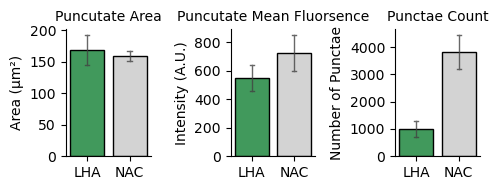

In [47]:

plot_cols = ['area','mean_intensity', 'count']
layout ="""ABC"""
plt_kws = {'hue': 'region', 
           'hue_order': ['LHA', 'NAC'],
           'palette': ['#32a856', 'lightgrey'],
           'errorbar': 'se', 
           'capsize': 0.1, 
           'linewidth': 1, 
           'edgecolor':'black'
           }

err_kws =  {'alpha': 0.8, 'lw': 1}


fig, ax = plt.subplot_mosaic(mosaic=layout, figsize=(5,2), sharex=True)
for a, c in zip(''.join(layout.split('\n')), plot_cols):
        df_plot = data.filter(pl.col('metric')==c).to_pandas()
        sns.barplot(data = df_plot, x = 'region', y = 'mean', ax = ax[a], **plt_kws, err_kws=err_kws)
        # ax[a].axhline(y=df_plot['mean'].mean(), xmin = 0.25, xmax = .75 )
        ax[a].yaxis.set_major_locator(plt.MaxNLocator(5))
        ax[a].set_title(c, fontsize=10)
        sns.despine(ax=ax[a])
        
sns.barplot(data = data.filter(pl.col('metric')=='area').to_pandas(), x = 'region', y = 'count', ax = ax['C'], **plt_kws, err_kws=err_kws)



ax['A'].set_ylabel('Area (μm²)')
ax['B'].set_ylabel('Intensity (A.U.)')
ax['C'].set_ylabel('Number of Punctae')

ax['A'].set_title('Puncutate Area', fontsize=10)
ax['B'].set_title('Puncutate Mean Fluorsence', fontsize=10)
ax['C'].set_title('Punctae Count', fontsize=10)
ax['A'].set_xlabel('')
ax['B'].set_xlabel('')
ax['C'].set_xlabel('')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(f"{path_to_save}/image_analysis.svg", format='svg', transparent=True, bbox_inches='tight')
stats.query("Source=='region'")
